In [23]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings as wn 
wn.filterwarnings('ignore')

import re
import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split


import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Embedding, LSTM, Dense 
from tensorflow.keras.layers import BatchNormalization, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 



In [3]:
train_df = pd.read_csv("../coronavirus_tweets_classification/Corona_NLP_train.csv", encoding='latin-1')
test_df = pd.read_csv("../coronavirus_tweets_classification/Corona_NLP_test.csv")

In [4]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


<Axes: xlabel='Sentiment'>

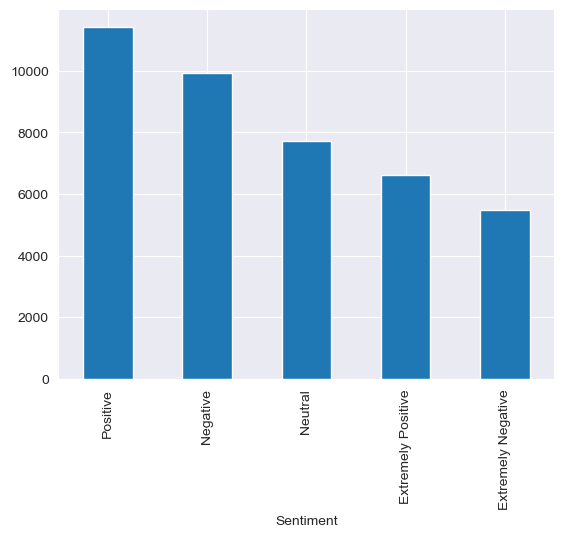

In [6]:
sns.set_style(style='darkgrid')
train_df['Sentiment'].value_counts().plot(kind='bar')

In [7]:
train_df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [8]:
train_df= train_df.drop(columns = ['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1)

In [9]:
train_df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [10]:
train_df['OriginalTweet'].duplicated().sum()

0

In [11]:
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Regex to remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Using regex to remove special characters except space

    text = text.lower()  # Preprocessing - lower casing all 

    stop_words = set(stopwords.words('english'))
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]
    cleaned_text = ' '.join(cleaned_words)

    return cleaned_text

In [12]:
train_df['Cleaned Tweets'] = train_df['OriginalTweet'].apply(clean_text)
train_df.head()

,OriginalTweet,Sentiment,Cleaned Tweets
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbie philgahan chrisitv httpstcoifz9fan2pa...
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid19 outbreak im paran...


In [13]:
le = LabelEncoder()
train_df['Senti_Label']= le.fit_transform(train_df['Sentiment'])

In [14]:
train_df.head()

,OriginalTweet,Sentiment,Cleaned Tweets,Senti_Label
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbie philgahan chrisitv httpstcoifz9fan2pa...,3
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,4
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,4
3,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...,4
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid19 outbreak im paran...,0


In [18]:
texts = train_df['Cleaned Tweets'].tolist()
vocab_size = 50000
max_length = 20

tokenizer = Tokenizer(num_words=vocab_size, oov_token ='<OOV>')
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
pad_seq = pad_sequences(sequences=sequences, maxlen=max_length, padding = 'post')


In [19]:
pad_seq[5]

array([16413,   765,   113,    89,     9, 11167,   507,    49,   575,
         558,   110,    29,    23,     5,    43,    45,   201, 23730,
         360, 23731], dtype=int32)

In [20]:
pad_seq.shape, train_df['Senti_Label'].shape

((41157, 20), (41157,))

In [21]:
y= to_categorical(x=train_df['Senti_Label'], num_classes=5)
pad_seq

array([[23719, 23720, 13082, ...,     0,     0,     0],
       [ 1005,   348,   293, ...,   959,  3345,   151],
       [    2,   713,  1692, ...,     0,     0,     0],
       ...,
       [   61,   144,  1535, ...,     0,     0,     0],
       [  619,  4169,    29, ...,     0,     0,     0],
       [ 2677,  2019,   294, ...,   648,     3,     1]], dtype=int32)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(pad_seq, y, test_size = 0.2)

In [25]:
x_train.shape, x_test.shape

((32925, 20), (8232, 20))

In [26]:
emb_dim = 16
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_length))
model.add(LSTM(units=20, activation='relu', return_sequences=True))
model.add(LSTM(units=20, activation='relu', return_sequences=False))
model.add(BatchNormalization())
model.add(Dense(units=5, activation='softmax'))
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

2024-04-28 02:36:11.380705: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-28 02:36:11.381839: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-28 02:36:11.381988: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-28 02:36:11.382048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-28 02:36:11.382270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)